In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import f
import random
import matplotlib.pyplot as plt

In [88]:
def generate_data(N =1500,dim = 10,clean_until=500,start_anom = 1000,seed = 42):
  # So N :- Number of samples in the dataset
  # dim :- Number of featues in the dataset
  # First 500 samples are considered to be normal
  # After 1000 samples there is anamoly in the dataset
  np.random.seed(seed) # Setting the randomness
  X = np.random.uniform(-2,2,size=(N,5)) # Initial 5 dimensions are considered to be independent
  # The other 5 dimensions are considered to be non-linearly dependent
  X4 = np.sin(3*X[:,0]) + 0.05*np.random.randn(N)
  X5 = X[:,1]*np.tan(2*X[:,2]) + 0.05*np.random.randn(N)
  X6 = np.exp(-X[:,3]) + 0.05*np.random.randn(N)
  X7 = X[:,4]**2 + 0.05*np.random.randn(N)
  X8 = np.log(np.abs(X[:,0]) + 1) + 0.05*np.random.randn(N)
  # Now we will stack these features
  # X4 ,X5 are one D matrices we have to convert into 2D for stacking
  # hence X4[:,None] :- shape(1500,1)
  X = np.hstack([X, X4[:,None], X5[:,None], X6[:,None], X7[:,None], X8[:,None]])

  anom_idx = []
  for idx in range(start_anom,N):
    d = np.random.randint(0,dim) # Here we are randomly chosing the dimension in which we want to add the disturbance.
    X[idx,d] *= 3
    anom_idx.append(idx)
  return X,np.array(anom_idx)


In [80]:
def normalize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    sigma[sigma < 0.001] = 0.001
    return (X - mu) / sigma, mu, sigma

In [70]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        y = self.encoder(x)
        x_recon = self.decoder(y)
        return x_recon, y

In [ ]:
def compute_RBCT(xnk, Qy, Pp):
    # xnk :- The normalized sample
    # Qy :- Inverse of covariance matrix
   # Pp is the projection of the input to latent space for first P components
    Ms = Pp @ Qy @ Pp.T
    Md = np.diag(Ms)
    Md[Md <= 0.001] = 0.001
    numerator = (Ms @ xnk.reshape(-1,1))**2
    return (numerator.flatten() / Md)

### Using RBCs  (Have to modify for Autoencoders)

In [ ]:
def ae_monitoring_fixed(
    Xraw,
    window_size=500,
    latent_dim=5,
    alpha=0.01,
    train_epochs=200,
    lr=1e-3
):
    N, n = Xraw.shape
    T2 = np.zeros(N)
    detected = []
    rbct_log = []

    # --- Initial training on clean window ---
    X0 = Xraw[:window_size]
    Xn0, mu, sigma = normalize(X0)
    model = Autoencoder(n, latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    Xt0 = torch.FloatTensor(Xn0)
    for epoch in range(train_epochs):
        x_recon, y = model(Xt0)
        loss = torch.mean((Xt0 - x_recon)**2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        _, Y0t = model(Xt0)
    Y0 = Y0t.numpy()  # shape (window_size × latent_dim)

    # Mahalanobis metric & control limit
    covY0 = np.cov(Y0, rowvar=False)
    Qy = np.linalg.inv(covY0)
    p, m = latent_dim, window_size
    Cl = (p*(m-1)*(m+1)) / (m*(m-p)) * f.ppf(1-alpha, p, m-p)

    # Effective loadings Pp = (W2 @ W1).T
    W1 = model.encoder[0].weight.detach().numpy()   # (32 × n)
    W2 = model.encoder[2].weight.detach().numpy()   # (p × 32)
    Pp = (W2 @ W1).T                               # (n × p)

    # Compute T2 for initial window
    for i in range(window_size):
        yi = Y0[i]
        T2[i] = yi @ Qy @ yi

    # --- Inference-only monitoring ---
    for k in range(window_size, N):
        xnew = (Xraw[k] - mu) / sigma
        with torch.no_grad():
            ynew = model.encoder(torch.FloatTensor(xnew)).numpy()
        T2[k] = ynew @ Qy @ ynew
        if T2[k] > Cl:
            detected.append(k)
            rbct = compute_RBCT(xnew, Qy, Pp)
            rbct_log.append((k, rbct))

    return T2, detected, rbct_log


### Without Using RBCs only detecting Anomalies

In [94]:
def ae_monitoring_fixed(
    Xraw,
    window_size=500,
    latent_dim=4,
    alpha=0.01,
    train_epochs=500,
    lr=1e-3
):
    N, n = Xraw.shape
    T2 = np.zeros(N) # For storing T2 score for each sample
    detected = [] # For storing the indexes where the T2 > CL

    # We will be training the model once for first Window samples
    # Then we will be inferencing for further samples.
    X0 = Xraw[:window_size]
    Xn0, mu, sigma = normalize(X0) # Normalising the data.
    model = Autoencoder(n, latent_dim) # Making the object of the class
    optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay = 1e-5) # Defining the optimiser
    Xt0 = torch.FloatTensor(Xn0) # Converting numpy array to tensor

    # The following is the standard training loop.
    for epoch in range(train_epochs):
        x_recon, y = model(Xt0)
        loss = torch.mean((Xt0 - x_recon)**2) # Vanilla Autoencoder MSE error.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    # Inferencing
    with torch.no_grad():
        _, Y0t = model(Xt0)
    Y0 = Y0t.numpy() # Latent representation of the input sample

    # compute Mahalanobis metric & control limit
    # As mentioned in the PCA code formula for finding the Control Limit
    covY0 = np.cov(Y0, rowvar=False)
    Qy = np.linalg.inv(covY0)
    p, m = latent_dim, window_size
    Cl = (p*(m-1)*(m+1)) / (m*(m-p)) * f.ppf(1-alpha, p, m-p)

    # compute T2 for window
    for i in range(window_size):
        yi = Y0[i]
        T2[i] = yi @ Qy @ yi

    # --- Inference-only loop ---
    for k in range(window_size, N):
        xnew = (Xraw[k] - mu) / sigma
        with torch.no_grad():
            ynew = model.encoder(torch.FloatTensor(xnew)).numpy()
        T2[k] = ynew @ Qy @ ynew
        if T2[k] > Cl:
            detected.append(k)

    return T2, detected,Cl


In [22]:
x,true_anom = generate_data()
print(x.shape)
x_axis = np.arange(1,(x.shape[0])+1)
print(x_axis)

(1500, 10)
[   0    1    2 ... 1497 1498 1499]


Epoch 0, Loss: 1.0225334167480469
Epoch 50, Loss: 0.8435526490211487
Epoch 100, Loss: 0.637662947177887
Epoch 150, Loss: 0.4831634759902954
Epoch 200, Loss: 0.41773563623428345
Epoch 250, Loss: 0.3746691644191742
Epoch 300, Loss: 0.33462563157081604
Epoch 350, Loss: 0.3074458837509155
Epoch 400, Loss: 0.29379597306251526
Epoch 450, Loss: 0.28103968501091003
Injected anomalies at: [np.int64(1000), np.int64(1001), np.int64(1002), np.int64(1003), np.int64(1004), np.int64(1005), np.int64(1006), np.int64(1007), np.int64(1008), np.int64(1009), np.int64(1010), np.int64(1011), np.int64(1012), np.int64(1013), np.int64(1014), np.int64(1015), np.int64(1016), np.int64(1017), np.int64(1018), np.int64(1019), np.int64(1020), np.int64(1021), np.int64(1022), np.int64(1023), np.int64(1024), np.int64(1025), np.int64(1026), np.int64(1027), np.int64(1028), np.int64(1029), np.int64(1030), np.int64(1031), np.int64(1032), np.int64(1033), np.int64(1034), np.int64(1035), np.int64(1036), np.int64(1037), np.int64

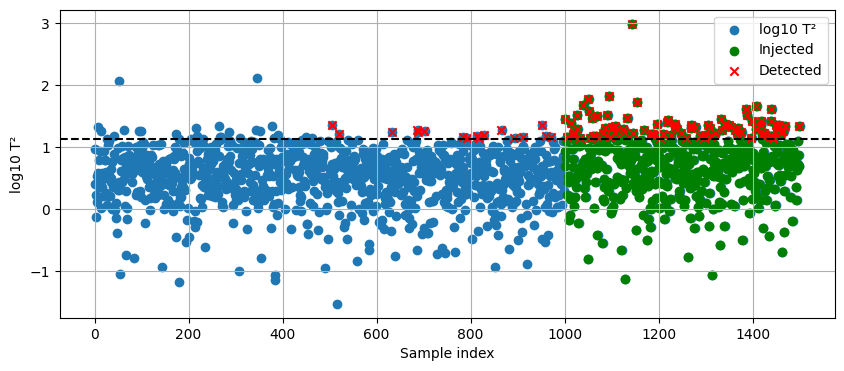

In [96]:
if __name__ == "__main__":
    X, true_anom = generate_data()
    T2, det,Cl = ae_monitoring_fixed(X)
    x_axis = np.arange(1,X.shape[0]+1)
    print("Injected anomalies at:", sorted(true_anom))
    print("Detected by AE at   :", det)
    print("Number of detected anomalies : ",len(det))
    # plot T2
    plt.figure(figsize=(10,4))
    plt.scatter(x_axis,np.log10(T2), label='log10 T²')
    plt.scatter(true_anom, np.log10(T2[true_anom]), c='g', marker='o', label='Injected')
    plt.scatter(det,         np.log10(T2[det]),         c='r', marker='x', label='Detected')
    plt.axhline(np.log10(Cl), color='k', linestyle='--')
    plt.legend(); plt.xlabel('Sample index'); plt.ylabel('log10 T²'); plt.grid()

Detected: [538, 540, 576, 639, 700, 733, 741, 748, 761, 791, 877, 968, 975, 995, 1000, 1010, 1017, 1019, 1024, 1026, 1027, 1034, 1040, 1047, 1050, 1052, 1058, 1059, 1068, 1094, 1102, 1106, 1112, 1124, 1125, 1127, 1133, 1134, 1143, 1145, 1148, 1154, 1156, 1157, 1166, 1168, 1188, 1193, 1197, 1204, 1217, 1219, 1220, 1226, 1231, 1237, 1241, 1247, 1259, 1263, 1285, 1292, 1296, 1297, 1305, 1306, 1309, 1315, 1316, 1322, 1332, 1334, 1347, 1349, 1351, 1368, 1385, 1386, 1388, 1391, 1397, 1398, 1403, 1407, 1408, 1412, 1418, 1419, 1423, 1427, 1437, 1438, 1440, 1445, 1449, 1453, 1454, 1461, 1468, 1471]
100


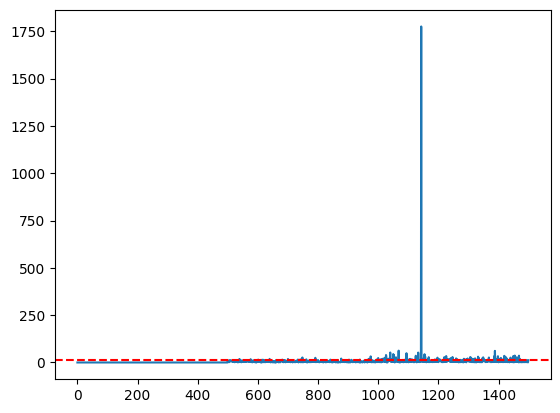

In [99]:
def ae_monitoring_combined(
    Xraw,
    window_size=500,
    latent_dim=5,
    alpha=0.01,
    train_epochs=500,
    lr=1e-3,
    lamb=0.5    # weight on reconstruction error
):
    N, n = Xraw.shape
    scores = np.zeros(N)
    detected = []

    # Training the  AE on first window
    X0 = Xraw[:window_size]
    Xn0, mu, sigma = normalize(X0)
    model = Autoencoder(n, latent_dim)
    opt = optim.Adam(model.parameters(), lr=lr)
    Xt0 = torch.FloatTensor(Xn0)
    for _ in range(train_epochs):
        x_recon, y = model(Xt0)
        loss = torch.mean((Xt0 - x_recon)**2)
        opt.zero_grad(); loss.backward(); opt.step()

    # Compute latent cov & T² metric
    with torch.no_grad():
        _, Y0t = model(Xt0)
    Y0 = Y0t.numpy()
    covY0 = np.cov(Y0, rowvar=False)
    Qy = np.linalg.inv(covY0)
    p, m = latent_dim, window_size
    Cl = (p*(m-1)*(m+1))/(m*(m-p)) * f.ppf(1-alpha, p, m-p)

    # Inference loop
    for k in range(window_size, N):
        xk = Xraw[k]
        xkn, = (xk - mu) / sigma,

        # reconstruction error
        xt = torch.FloatTensor(xkn)
        with torch.no_grad():
            x_recon, yk = model(xt)
        recon_err = float(((xt - x_recon)**2).mean())

        # T2 score
        yk = yk.numpy()
        T2 = yk @ Qy @ yk

        # Combining T2 Score and reconstruction error
        total = T2 + lamb * recon_err
        scores[k] = total

        if total > Cl:
            detected.append(k)

    return scores, detected, Cl


if __name__=="__main__":
    X, true_anom = generate_data()
    scores, det, Cl = ae_monitoring_combined(X, lamb=0.1)
    print("Detected:", det)
    print(len(det))
    plt.plot(scores, label="T2 + λ·recon")
    plt.axhline(Cl, color='r', linestyle='--')
    plt.show()


### Main function for the RBC based code

In [ ]:
if __name__ == "__main__":
    X, true_anom = generate_data()
    T2, det, rbct = ae_monitoring_fixed(X)

    print("Injected anomalies at:", sorted(true_anom))
    print("Detected by AE at   :", det)

    # Plot results
    plt.figure(figsize=(10,4))
    plt.plot(np.log10(T2), label='log10 T²')
    plt.scatter(true_anom, np.log10(T2[true_anom]), c='g', marker='o', label='Injected')
    plt.scatter(det,         np.log10(T2[det]),         c='r', marker='x', label='Detected')
    p, m, alpha = 5, 500, 0.01
    Cl = (p*(m-1)*(m+1)) / (m*(m-p)) * f.ppf(1-alpha, p, m-p)
    plt.axhline(np.log10(Cl), color='k', linestyle='--')
    plt.legend(); plt.xlabel('Sample index'); plt.ylabel('log10 T²'); plt.grid()
    plt.show()

# AEO

In [155]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import f
import matplotlib.pyplot as plt

In [156]:
def generate_data(N=1500, dim=5, clean_until=500, start_anom=1000, seed=42):
    np.random.seed(seed)
    X = np.random.uniform(-2, 2, size=(N, dim))

    X[:, 2] = np.sin(X[:, 0]) + 0.05 * np.random.randn(N)
    X[:, 3] = np.log1p(X[:, 1]**2) + 0.05 * np.random.randn(N)
    X[:, 4] = 1 / (1 + np.exp(-X[:, 0] * X[:, 1])) + 0.05 * np.random.randn(N)

    # Introducing Anomalies
    anom_idx = []
    for i in range(start_anom, N):
        d = np.random.randint(0, dim)
        X[i, d] *= 3
        anom_idx.append(i)

    return X, np.array(anom_idx)


In [157]:
def normalize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    sigma[sigma<0.01] = 0.01
    return (X-mu)/sigma, mu, sigma

In [158]:
class AutoencoderAEO(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder=nn.Sequential(
            nn.Linear(input_dim,4), nn.ReLU(), nn.Linear(4,input_dim)
        )
        self.decoder=nn.Sequential(
            nn.Linear(input_dim,4), nn.ReLU(), nn.Linear(4,input_dim)
        )
    def forward(self,x):
        y=self.encoder(x)
        x_recon=self.decoder(y)
        return x_recon,y

In [159]:
def aeo_loss(model,x,x_recon,y,Q,alpha=1.,beta=0.5,gamma=0.1):
    j1=alpha*torch.mean((x-x_recon)**2)
    y0=(y-y.mean(0,keepdim=True)).T
    j2=beta*torch.trace(y0.T@Q@y0)
    j3=gamma*sum(p.pow(2).sum() for p in model.parameters())
    return j1+j2+j3, j1, j2, j3

In [160]:
def tune_q_collect_variances(data, q_values, epochs=300, lr=1e-3):
    """
    For each q in q_values:
      -  Q = diag([0,1*q,2*q,3*q,4*q])
      - We will train the autoencoder on clean dataset
      - Find the ideal value of q were ordering would take place
      - Record latent variances for plotting and visualising
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    X = torch.FloatTensor(data).to(device)
    latent_dim = data.shape[1]
    latent_vars_matrix = []

    for q in q_values:
        # construct Q as specified
        weights = torch.FloatTensor([0, 1*q, 2*q, 3*q, 4*q]).to(device)
        Q = torch.diag(weights)

        # initialize model and optimizer
        model = AutoencoderAEO(latent_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # train once on the data
        for epoches in range(epochs):
            x_recon, y = model(X)
            loss, _, _, _ = aeo_loss(model, X, x_recon, y, Q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if epoches%50==0:
             print(f"Epoch {epoches}, Loss: {loss.item()}")

        # collect variances of the latent code
        with torch.no_grad():
            y_out = model.encoder(X).cpu().numpy()
        vars_ = np.var(y_out, axis=0)
        latent_vars_matrix.append(vars_)

    return np.vstack(latent_vars_matrix)

In [161]:
def plot_q_variances(latent_vars_matrix, q_values):
    """
    Plot variance of each latent dimension as a function of q.
    """
    plt.figure(figsize=(8,4))
    m = latent_vars_matrix.shape[1]
    for i in range(m):
        plt.plot(q_values, latent_vars_matrix[:, i], marker='o', label=f'Var(y{i+1})')
    plt.xlabel('q')
    plt.ylabel('Variance')
    plt.title('Ordered Latent Variances vs q')
    plt.xticks(q_values)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [162]:
data1, tp = generate_data()
print(data1.shape)
good_data = data1[:500]
print(good_data.shape)

(1500, 5)
(500, 5)


Epoch 0, Loss: 110.94332885742188
Epoch 50, Loss: 42.36505889892578
Epoch 100, Loss: 19.14684295654297
Epoch 150, Loss: 10.060818672180176
Epoch 200, Loss: 6.099267482757568
Epoch 250, Loss: 4.160398960113525
Epoch 0, Loss: 66.90283966064453
Epoch 50, Loss: 17.94147491455078
Epoch 100, Loss: 5.979200839996338
Epoch 150, Loss: 3.1007609367370605
Epoch 200, Loss: 2.0876357555389404
Epoch 250, Loss: 1.6212495565414429
Epoch 0, Loss: 65.41417694091797
Epoch 50, Loss: 22.142059326171875
Epoch 100, Loss: 10.097636222839355
Epoch 150, Loss: 5.58408784866333
Epoch 200, Loss: 3.516087055206299
Epoch 250, Loss: 2.4348292350769043
Epoch 0, Loss: 318.6087951660156
Epoch 50, Loss: 120.6742935180664
Epoch 100, Loss: 51.01696014404297
Epoch 150, Loss: 26.436580657958984
Epoch 200, Loss: 16.562646865844727
Epoch 250, Loss: 11.69352912902832
Epoch 0, Loss: 68.90333557128906
Epoch 50, Loss: 14.031329154968262
Epoch 100, Loss: 5.028036117553711
Epoch 150, Loss: 2.6945841312408447
Epoch 200, Loss: 1.92117

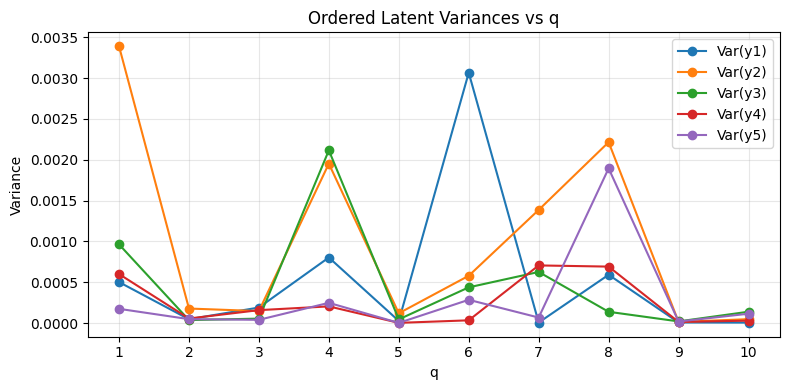

In [163]:
if __name__ == '__main__':
    q_values = list(range(1, 11))
    latent_vars = tune_q_collect_variances(good_data, q_values,
                                           epochs=300, lr=1e-3)
    plot_q_variances(latent_vars, q_values)


In [167]:
def aeo_monitoring_after_tuning(
    data, best_q,
    window_size=500,
    alpha=0.01,
    epochs=200,
    lr=1e-3
):
    N, n = data.shape
    # Finding the T2 score for the initial window
    X0 = data[:window_size]
    Xn0, mu, sigma = normalize(X0)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    Xt0 = torch.FloatTensor(Xn0).to(device)

    # Q matrix from q
    weights = torch.FloatTensor([0,1*best_q,2*best_q,3*best_q,4*best_q]).to(device)
    Q = torch.diag(weights)

    model = AutoencoderAEO(n).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    for _ in range(epochs):
        x_r, y = model(Xt0)
        loss,_,_,_ = aeo_loss(model, Xt0, x_r, y, Q)
        opt.zero_grad(); loss.backward(); opt.step()

    #  Extract latent and select principal components similar to the PCA
    with torch.no_grad():
        _, Y0t = model(Xt0)
    Y0 = Y0t.cpu().numpy()
    variances = Y0.var(axis=0)
    cum_var = variances.cumsum() / variances.sum()
    p = max(2, int((cum_var < 0.9).sum()) + 1)

    #  Mahalanobis metric with regularization
    Y0_centered = Y0[:, :p] - Y0[:, :p].mean(axis=0)
    covY = np.cov(Y0_centered.T) + 1e-6 * np.eye(p)
    Qy = np.linalg.inv(covY)

    m = window_size
    Cl = (p*(m-1)*(m+1)) / (m*(m-p)) * f.ppf(1-alpha, p, m-p)

    # Inference
    T2 = np.zeros(N)
    detected = []
    for k in range(window_size, N):
        xk = (data[k] - mu) / sigma
        with torch.no_grad():
            yk = model.encoder(torch.FloatTensor(xk).to(device)).cpu().numpy()
        yk_centered = yk[:p] - Y0[:, :p].mean(axis=0)
        T2[k] = yk_centered @ Qy @ yk_centered
        if T2[k] > Cl:
            detected.append(k)

    return T2, detected, Cl


Injected anomalies at: [np.int64(1000), np.int64(1001), np.int64(1002), np.int64(1003), np.int64(1004), np.int64(1005), np.int64(1006), np.int64(1007), np.int64(1008), np.int64(1009), np.int64(1010), np.int64(1011), np.int64(1012), np.int64(1013), np.int64(1014), np.int64(1015), np.int64(1016), np.int64(1017), np.int64(1018), np.int64(1019), np.int64(1020), np.int64(1021), np.int64(1022), np.int64(1023), np.int64(1024), np.int64(1025), np.int64(1026), np.int64(1027), np.int64(1028), np.int64(1029), np.int64(1030), np.int64(1031), np.int64(1032), np.int64(1033), np.int64(1034), np.int64(1035), np.int64(1036), np.int64(1037), np.int64(1038), np.int64(1039), np.int64(1040), np.int64(1041), np.int64(1042), np.int64(1043), np.int64(1044), np.int64(1045), np.int64(1046), np.int64(1047), np.int64(1048), np.int64(1049), np.int64(1050), np.int64(1051), np.int64(1052), np.int64(1053), np.int64(1054), np.int64(1055), np.int64(1056), np.int64(1057), np.int64(1058), np.int64(1059), np.int64(1060), 

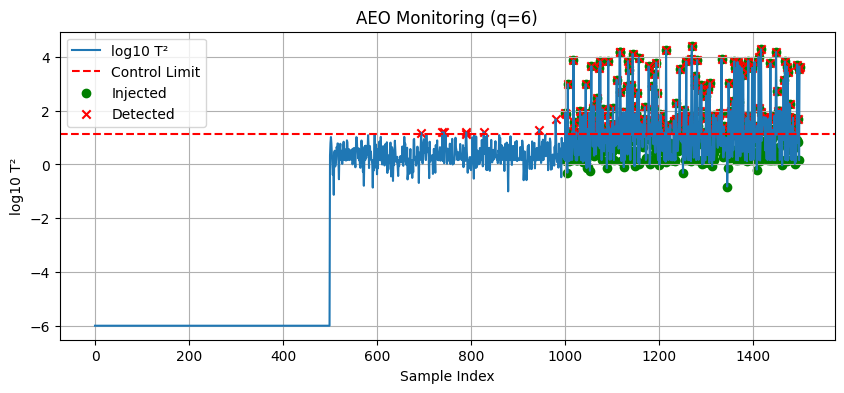

In [169]:
if __name__ == '__main__':
    best_q = 6
    X = data1
    T2_scores, detected, control_limit = aeo_monitoring_after_tuning(
        X, best_q,
        window_size=500,
        alpha=0.01,
        epochs=200,
        lr=1e-3
    )

    print("Injected anomalies at:", sorted(tp))
    print("Detected by AEO at   :", detected)
    print(len(detected))

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(np.log10(T2_scores + 1e-6), label='log10 T²')
    plt.axhline(np.log10(control_limit), color='r', linestyle='--', label='Control Limit')
    plt.scatter(tp, np.log10(T2_scores[tp] + 1e-6), c='g', marker='o', label='Injected')
    plt.scatter(detected, np.log10(T2_scores[detected] + 1e-6), c='r', marker='x', label='Detected')
    plt.xlabel('Sample Index')
    plt.ylabel('log10 T²')
    plt.title(f'AEO Monitoring (q={best_q})')
    plt.legend(); plt.grid(True); plt.show()


#Old

In [102]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [103]:

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

In [104]:

def generate_5var_data(N=300):
    np.random.seed(42)
    x1 = np.random.uniform(-2, 2, N)
    x2 = np.random.uniform(-2, 2, N)
    x3 = np.random.uniform(-2, 2, N)
    x4 = np.sin(3*x1) + np.random.normal(0, 0.1, N)
    x5 = x2 - np.tan(0.5*x3) + np.random.normal(0, 0.1, N)
    return np.column_stack([x1, x2, x3, x4, x5])

In [105]:
class Autoencoder_OrderedVariance(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 4),
            nn.ReLU(),
            nn.Linear(4, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 4),
            nn.ReLU(),
            nn.Linear(4, input_dim)
        )

    def forward(self, x):
        y = self.encoder(x)
        x_recon = self.decoder(y)
        return x_recon, y

In [106]:
def normalize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    sigma[sigma < 0.01] = 0.01
    return (X - mu) / sigma, mu, sigma

In [108]:
  def ae_loss(model, x, x_recon, y, Q, alpha=1, beta=0.7, gamma=0.1):
      # Reconstruction loss
      recon_loss = alpha * torch.mean((x - x_recon)**2)

      # Variance regularization (Ordering loss)
      y_centered = (y - torch.mean(y, dim=0)).T
      var_loss = beta * torch.trace(y_centered.T @Q @ y_centered)

      # Weight regularization (L2)
      l2_reg = gamma * sum(p.pow(2.0).sum() for p in model.parameters())

      return recon_loss + var_loss + l2_reg, recon_loss, var_loss, l2_reg

In [117]:
def train_aeo(data,q_values,input_dim):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = {
        'latent_vars': [],
        'recon_loss': [],
        'var_loss': [],
        'weight_loss': [],
        'epoch_losses': {q: [] for q in q_values}
    }

    X = torch.FloatTensor(data).to(device)
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    for q in q_values:


        model = Autoencoder_OrderedVariance(input_dim, input_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        if input_dim == 2:
            Q = torch.diag(torch.FloatTensor([1, q**2])).to(device)
        else:
            Q = torch.diag(torch.FloatTensor([0, 1*q, 2*q, 3*q, 4*q])).to(device)

        print(f"\nTraining for q={q}:")
        for epoch in range(800):
            x_recon, y = model(X)
            total_loss, recon_loss, var_loss, weight_loss = ae_loss(model, X, x_recon, y, Q)

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            results['epoch_losses'][q].append(total_loss.item())

            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Total Loss = {total_loss.item():.4f}, "
                      f"Recon = {recon_loss.item():.4f}, Var = {var_loss.item():.4f}, "
                      f"Weight = {weight_loss.item():.4f}")
            if epoch % 100 == 0:
                var_y = torch.var(y, dim=0).detach().cpu().numpy()
                print(f"Epoch {epoch}: Var(Y) = {var_y}")

        with torch.no_grad():
            y = model.encoder(X)
            latent_vars = torch.var(y, dim=0).cpu().numpy()

        results['latent_vars'].append(latent_vars)
        results['recon_loss'].append(recon_loss.item())
        results['var_loss'].append(var_loss.item())
        results['weight_loss'].append(weight_loss.item())

    return results


Training for q=1:
Epoch 0: Total Loss = 108.8614, Recon = 1.3726, Var = 106.7346, Weight = 0.7542
Epoch 0: Var(Y) = [0.03028092 0.04237688 0.01997064 0.04755097 0.0712472 ]
Epoch 100: Total Loss = 24.1964, Recon = 1.3385, Var = 22.4180, Weight = 0.4399
Epoch 100: Var(Y) = [0.00423013 0.0099309  0.00330009 0.01082806 0.01452358]
Epoch 200: Total Loss = 8.8261, Recon = 1.3266, Var = 7.2204, Weight = 0.2791
Epoch 200: Var(Y) = [0.00061225 0.00359551 0.00106812 0.00336683 0.00466634]
Epoch 300: Total Loss = 4.3843, Recon = 1.3198, Var = 2.8676, Weight = 0.1969
Epoch 300: Var(Y) = [8.9362584e-05 1.5485089e-03 4.3823785e-04 1.3036299e-03 1.8413002e-03]
Epoch 400: Total Loss = 2.6179, Recon = 1.3149, Var = 1.1467, Weight = 0.1563
Epoch 400: Var(Y) = [9.8277724e-06 6.4817898e-04 1.6387465e-04 5.6776230e-04 6.9983193e-04]
Epoch 500: Total Loss = 1.8219, Recon = 1.3120, Var = 0.3724, Weight = 0.1375
Epoch 500: Var(Y) = [7.9125800e-07 3.2637198e-04 4.9271126e-05 2.5834210e-04 1.4478316e-04]
Epoc

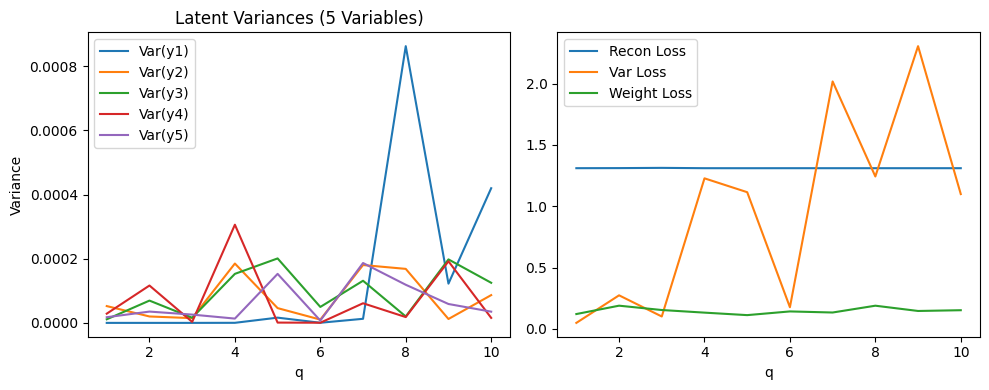

In [119]:
data_5var = generate_5var_data()

q_values = np.arange(1, 11)
results_5var = train_aeo(data_5var,q_values,input_dim=5)

plt.figure(figsize=(10,4))
plt.subplot(121)
for i in range(5):
    plt.plot(q_values, [v[i] for v in results_5var['latent_vars']], label=f'Var(y{i+1})')

plt.xlabel('q')
plt.ylabel('Variance')
plt.legend()
plt.title('Latent Variances (5 Variables)')
# Plot Figure 3(b): Loss Components
plt.subplot(122)
plt.plot(q_values, results_5var['recon_loss'], label='Recon Loss')
plt.plot(q_values, results_5var['var_loss'], label='Var Loss')
plt.plot(q_values, results_5var['weight_loss'], label='Weight Loss')
plt.xlabel('q')
plt.legend()
plt.tight_layout()